### Visual Search Engine
Here are the steps for implementing the project:
1. Input (img, text):  Vector Embedding | CLIP, ViT 
2. All visual document (img): Vector Embedding | CLIP, ViT
3. Check the similarity between the input and the visual documents | FAISS
4. Show the results

### FAISS
Faiss (Facebook AI Similarity Search) is a library that allows developers to quickly search for embeddings of multimedia documents that are similar to each other. It is actually a toolkit for indexing method and for efficient similarity search and clustering of dense vectors. It is optimized for searching through millions or billions of high-dimensional vectors quickly.

#### Monut Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Install and Import Necessary Libraries

In [4]:
!pip install -q faiss-cpu ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.9 MB/s eta 0:00:00


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import clip
import faiss
import numpy as np
from PIL import Image
from tqdm import tqdm
import gradio as gr

#### Import Dataset

In [7]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# CIFAR-10 classes
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

# Load CIFAR-10 dataset (first 1000 images)
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
images, labels = zip(*[dataset[i] for i in range(2000)])

print(f"Images shape: {len(images)}")

100%|██████████| 170M/170M [00:05<00:00, 28.6MB/s]


Images shape: 2000


#### Load Models

In [9]:
# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Load ViT model (torchvision)
vit_model = models.vit_b_16(pretrained=True).to(device)
vit_model.eval()
vit_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 86.9MiB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 183MB/s]


#### Extract Features for Each Models

In [11]:
# Extract embeddings for all images using both models
def extract_features(model_type):
    features = []
    for img in tqdm(images, desc=f"Extracting {model_type} features"):
        if model_type == "CLIP":
            tensor = clip_preprocess(img).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = clip_model.encode_image(tensor).cpu().numpy()
        else:  # ViT
            tensor = vit_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                emb = vit_model(tensor).cpu().numpy()
        features.append(emb)
    return np.vstack(features).astype("float32")

# Build FAISS indices
clip_feats = extract_features("CLIP")
vit_feats = extract_features("ViT")

print(f"\nCLIP features dimensions: {clip_feats.shape}")
print(f"ViT features dimensions: {vit_feats.shape}")

Extracting ViT features: 100%|██████████| 2000/2000 [00:32<00:00, 61.20it/s]


CLIP features dimensions: (2000, 512)
ViT features dimensions: (2000, 1000)


#### Prepare the Indices for Searching: IndexFlatL2

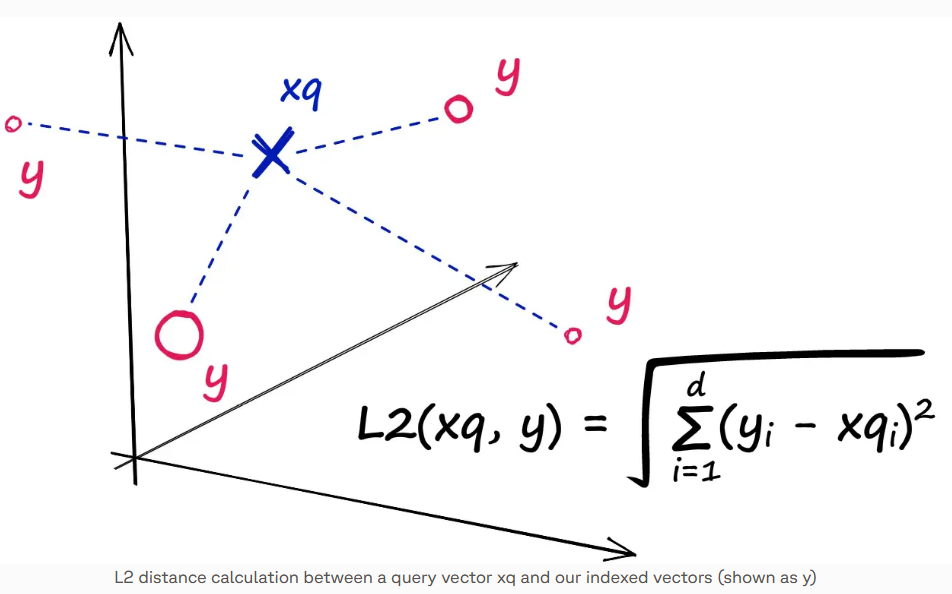

In [13]:
# Passing the dimentionality for each model with IndexFlatL2
clip_index = faiss.IndexFlatL2(clip_feats.shape[1])
clip_index.add(clip_feats)

vit_index = faiss.IndexFlatL2(vit_feats.shape[1])
vit_index.add(vit_feats)

print("✅ FAISS indices built.")

✅ FAISS indices built.


In [22]:
# Check the dimensionality
print(f" CLIP Index Dimension: {clip_index.ntotal}")
print(f" ViT Index Dimension: {vit_index.ntotal}")

 CLIP Index Dimension: 2000
 ViT Index Dimension: 2000


#### Inference Search function

In [ ]:
def search_images(prompt, uploaded_img, model_choice):
    if model_choice == "CLIP":
        if not prompt.strip():
            return gr.update(visible=True, value="❌ Please enter a text prompt for CLIP."), []
        with torch.no_grad():
            tokens = clip.tokenize([prompt]).to(device)
            query_feat = clip_model.encode_text(tokens).cpu().numpy()
        _, idxs = clip_index.search(query_feat, k=6)

    elif model_choice == "ViT":
        if uploaded_img is None:
            return gr.update(visible=True, value="❌ Please upload an image for ViT mode."), []
        try:
            image = vit_transform(uploaded_img).unsqueeze(0).to(device)
            with torch.no_grad():
                query_feat = vit_model(image).cpu().numpy()
            _, idxs = vit_index.search(query_feat, k=6)
        except Exception as e:
            return gr.update(visible=True, value=f"❌ Error processing image: {e}"), []

    else:
        return gr.update(visible=True, value="❌ Invalid model selected."), []

    results = [(images[i].resize((32, 32)), f"{cifar_classes[labels[i]]}") for i in idxs[0]]

    return gr.update(visible=False), results


#### Building UI app with Gradio

In [ ]:
# Gradio UI with custom style
with gr.Blocks(theme=gr.themes.Soft(), css="""
.gradio-container {
    background: linear-gradient(135deg, #4F46E5, #800020);
    min-height: 100vh;
    margin: 0;
    padding: 20px;
}

.gallery-item-label {
    background-color: #3B82F6 !important;  /* Soft blue */
    color: white !important;
    font-weight: bold;
    padding: 4px 6px;
    border-radius: 6px;
    text-align: center;
}

#generate-btn {
    background-color: #4F46E5;
    color: white;
    font-size: 20px;
    font-weight: bold;
    border-radius: 12px;
    padding: 14px 28px;
    border: none;
    margin: 20px auto;
    display: block;
    width: fit-content;
    transition: background 0.3s ease;
}
#generate-btn:hover {
    background-color: #800020;
    cursor: pointer;
}

#error-msg {
    color: white;
    font-weight: bold;
    text-align: center;
    margin-top: 10px;
    background-color: #800020;
    padding: 10px;
    border-radius: 10px;
}

input[type="radio"]:checked {
    background-color: #800020 !important;
    border-color: #800020 !important;
    color: white !important;
}
""") as demo:

    gr.Markdown("## 🔍 Smart Visual Search Engine")
    gr.Markdown("Search CIFAR-10 images by either entering a **text prompt** (CLIP mode) or **uploading an image** (ViT mode).")

    with gr.Row():
        prompt = gr.Textbox(label="Text Prompt (used in CLIP mode)", placeholder="e.g., a red car")
        uploaded_img = gr.Image(label="Upload Image (used in ViT mode)", type="pil")
        model_choice = gr.Radio(choices=["CLIP", "ViT"], label="Model", value="CLIP")

    search_button = gr.Button("Search Images", elem_id="generate-btn")
    error_msg = gr.Label(visible=False, elem_id="error-msg")
    results = gr.Gallery(label="Top 6 Similar CIFAR-10 Images", columns=3, rows=2)

    # Trigger search
    search_button.click(
        fn=search_images,
        inputs=[prompt, uploaded_img, model_choice],
        outputs=[error_msg, results]
    )

    # Toggle prompt/image visibility
    def toggle_fields(choice):
        return (
            gr.update(visible=choice == "CLIP"),
            gr.update(visible=choice == "ViT")
        )
    
    # Update the visibility of prompt (gr.Textbox) or image (gr.Image)
    model_choice.change(
        fn=toggle_fields,
        inputs=model_choice,
        outputs=[prompt, uploaded_img]
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://622df17e7e75c3bd88.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
